<a href="https://colab.research.google.com/github/Vecheslav-Eremeev/keras_projects/blob/main/People_faces_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

In [3]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
faces.data.shape

(2370, 2914)

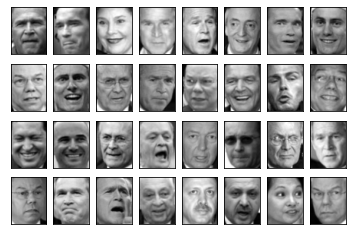

In [5]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  axi.imshow(faces.images[i], cmap='gray')

In [6]:
model = PCA(100).fit(faces.data)

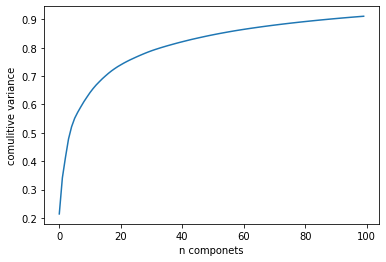

In [7]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n componets')
plt.ylabel('comulitive variance');

In [8]:
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [9]:
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
  ax = ax or plt.gca()

  proj = model.fit_transform(data)
  ax.plot(proj[:,0], proj[:,1], '.k')

  if images is not None:
    min_dist = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
    show_images = np.array([2 * proj.max(0)])
    for i in range(data.shape[0]):
      dist = np.sum((proj[i] - show_images) ** 2, 1)
      if np.min(dist) < min_dist:
        continue
      show_images = np.vstack([show_images, proj[i]])
      imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
      ax.add_artist(imagebox)

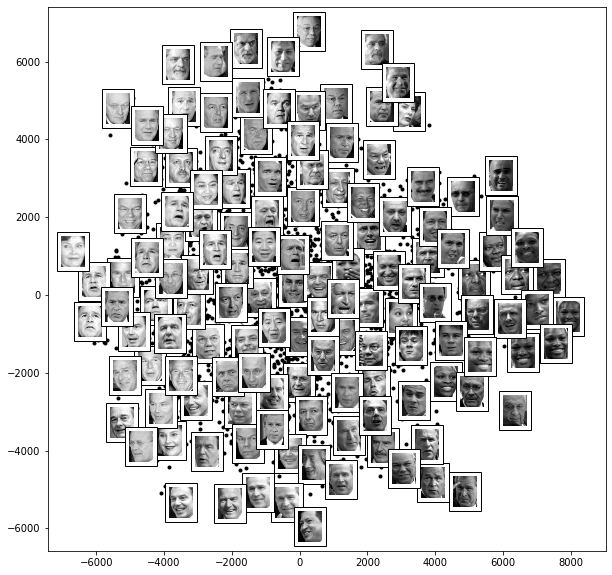

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2])

In [11]:
faces.target

array([ 8,  4, 21, ...,  8, 10,  8])

In [12]:
faces.images.shape

(2370, 62, 47)

In [13]:
X = faces.images.reshape(-1, 62, 47, 1)

In [14]:
y = to_categorical(faces.target)

In [15]:
X.shape, y.shape

((2370, 62, 47, 1), (2370, 34))

In [16]:
X = X.astype('float') / 255

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

In [20]:
model = Sequential([
    Conv2D(96, (11, 11), padding='same', activation='relu', input_shape=(62, 47, 1)),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(256, (5, 5), activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),

    Dense(1024, activation='tanh'),
    Dropout(0.5),
    Dense(1024, activation='tanh'),
    Dropout(0.5),
    Dense(34, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 47, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 23, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 23, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 11, 256)      0         
 2D)                                                             
                                                        

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [22]:
batch_size = 64
epochs = 50

In [23]:
callbacks_list = [
    EarlyStopping(monitor='val_acc', patience=5),
    ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True)
]

In [24]:
data_gen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [25]:
history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test),
                             steps_per_epoch = X_train.shape[0] // batch_size, callbacks=callbacks_list)

Epoch 1/50
31/31 [==============================] - 15s 137ms/step - loss: 3.8587 - acc: 0.1333 - val_loss: 3.8390 - val_acc: 0.0197
Epoch 2/50
31/31 [==============================] - 3s 82ms/step - loss: 3.5027 - acc: 0.1867 - val_loss: 4.3503 - val_acc: 0.0927
Epoch 3/50
31/31 [==============================] - 3s 89ms/step - loss: 3.3245 - acc: 0.2103 - val_loss: 3.3191 - val_acc: 0.1376
Epoch 4/50
31/31 [==============================] - 3s 96ms/step - loss: 3.0925 - acc: 0.2482 - val_loss: 3.2412 - val_acc: 0.2669
Epoch 5/50
31/31 [==============================] - 3s 94ms/step - loss: 2.9470 - acc: 0.2631 - val_loss: 3.1941 - val_acc: 0.2725
Epoch 6/50
31/31 [==============================] - 3s 91ms/step - loss: 2.7117 - acc: 0.3149 - val_loss: 3.1404 - val_acc: 0.2444
Epoch 7/50
31/31 [==============================] - 3s 91ms/step - loss: 2.5554 - acc: 0.3390 - val_loss: 2.8481 - val_acc: 0.3034
Epoch 8/50
31/31 [==============================] - 3s 83ms/step - loss: 2.3809 -

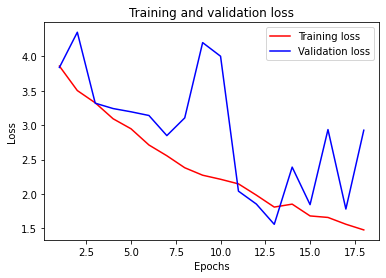

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_plot = np.arange(1, len(loss) + 1)
plt.clf()

plt.plot(epochs_plot, loss, 'r', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

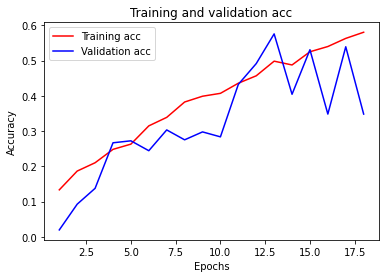

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs_plot, acc, 'r', label='Training acc')
plt.plot(epochs_plot, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model = load_model('my_model.h5')

In [32]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 25ms/step - loss: 1.5586 - acc: 0.5758


[1.5586470365524292, 0.5758426785469055]